In [1]:
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
from matplotlib import style
import glob #to get file names
import numpy as np
import xarray as xr
import math
from pandas import Series

import gsw
import numpy as np
#from oceans.sw_extras import gamma_GP_from_SP_pt

from pathlib import Path
import ctd

#from ctd import DataFrame, Series, movingaverage, rosette_summary, lp_filter

#files_r = glob.glob('./*.ros')
files_c = glob.glob('./*_03Downcast.cnv')
#files_r
files_c

for f in files_c: 
    cast = ctd.from_cnv(f)
    down, up = cast.split()
    ID = f.split("\\")[1]
    ID = ID[:-4].split("_")
    ID = ID[0]+"_"+ID[2]+"_"+ID[4]
    down.to_csv(f"./ctd_{ID}_downcast.csv")


In [10]:
files = glob.glob('./*.csv')

frames = []

for f in files: 
    df = pd.read_csv(f)
    
    ID = f.split("\\")[1]
    ID = ID[:-4].split("_")
    
    camp = ID[1]
    station = ID[2]
    sample_id = ID[3]
    date = ID[4]
    
    maxd = df['Pressure [dbar]'].max()
    lat = df['latitude'].mean()
    lon = df['longitude'].mean()
    
    df_new = df
    
    df_new['year'] = camp
    df_new['Boat'] = station
    df_new['station'] = sample_id
    df_new['cast'] = date
    df_new['maxd'] = maxd
    df_new['lat'] = lat
    df_new['lon'] = lon
    
    frames.append(df_new)
    
ds = pd.concat(frames, axis=0)
ds

,Pressure [dbar],wetCDOM,flECO-AFL,c0uS/cm,nbf,latitude,longitude,sbeox0Mm/L,ph,potemp090C,sal00,sfdSM,flag,year,Boat,station,cast,maxd,lat,lon
0,-0.149,9.1263,0.6244,1377.1,0.0,29.28572,-80.80672,124.198,-2.097,24.4057,0.6968,1488.155,False,2023,Hogarth,Daytona,downcast,21.783,29.285075,-80.807430
1,-0.151,9.1263,0.5931,1421.9,0.0,29.28572,-80.80672,124.198,-2.097,24.4098,0.7204,1488.107,False,2023,Hogarth,Daytona,downcast,21.783,29.285075,-80.807430
2,-0.130,9.1263,0.5931,1467.4,0.0,29.28572,-80.80672,124.148,-2.097,24.4150,0.7444,1488.151,False,2023,Hogarth,Daytona,downcast,21.783,29.285075,-80.807430
3,-0.142,8.8135,0.5931,1513.3,0.0,29.28572,-80.80674,124.128,-2.097,24.4203,0.7687,1488.139,False,2023,Hogarth,Daytona,downcast,21.783,29.285075,-80.807430
4,-0.123,8.7524,0.5977,1533.7,0.0,29.28572,-80.80674,124.083,-2.097,24.4248,0.7794,1488.181,False,2023,Hogarth,Daytona,downcast,21.783,29.285075,-80.807430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
959,21.845,1.7485,0.9387,58343.0,0.0,28.15580,-80.31078,71.477,-1.973,28.5284,36.0718,54.392,False,2023,Hogarth,Sebast,downcast,22.152,28.155267,-80.310707
960,22.010,1.7638,0.9624,58341.0,0.0,28.15580,-80.31078,71.477,-1.973,28.5263,36.0719,53.047,False,2023,Hogarth,Sebast,downcast,22.152,28.155267,-80.310707
961,22.137,1.7562,0.9616,58339.0,0.0,28.15580,-80.31078,71.485,-1.974,28.5239,36.0725,51.320,False,2023,Hogarth,Sebast,downcast,22.152,28.155267,-80.310707
962,22.149,1.7638,0.9624,58337.0,0.0,28.15580,-80.31078,71.474,-1.974,28.5253,36.0700,49.135,False,2023,Hogarth,Sebast,downcast,22.152,28.155267,-80.310707


In [11]:
station_order = ds['station'].unique()
#station_orders = ['Daytona', 'Mer-off', 'Mos-off', 'Sebast', 'Fort-Pirce-offshore',]
max_depth = ds.groupby(['station'])['maxd'].max().reset_index()

station_orders = max_depth['station'].unique()
col_maxd = max_depth['maxd'].unique()
#col_maxd
print(station_order)
print(col_maxd)

max_depth

['Daytona' 'Fort-Pirce-offshore' 'Mer-off' 'Mos-off' 'Sebast']
[21.783 17.847 15.348 22.152]


,station,maxd
0,Daytona,21.783
1,Fort-Pirce-offshore,17.847
2,Mer-off,21.783
3,Mos-off,15.348
4,Sebast,22.152


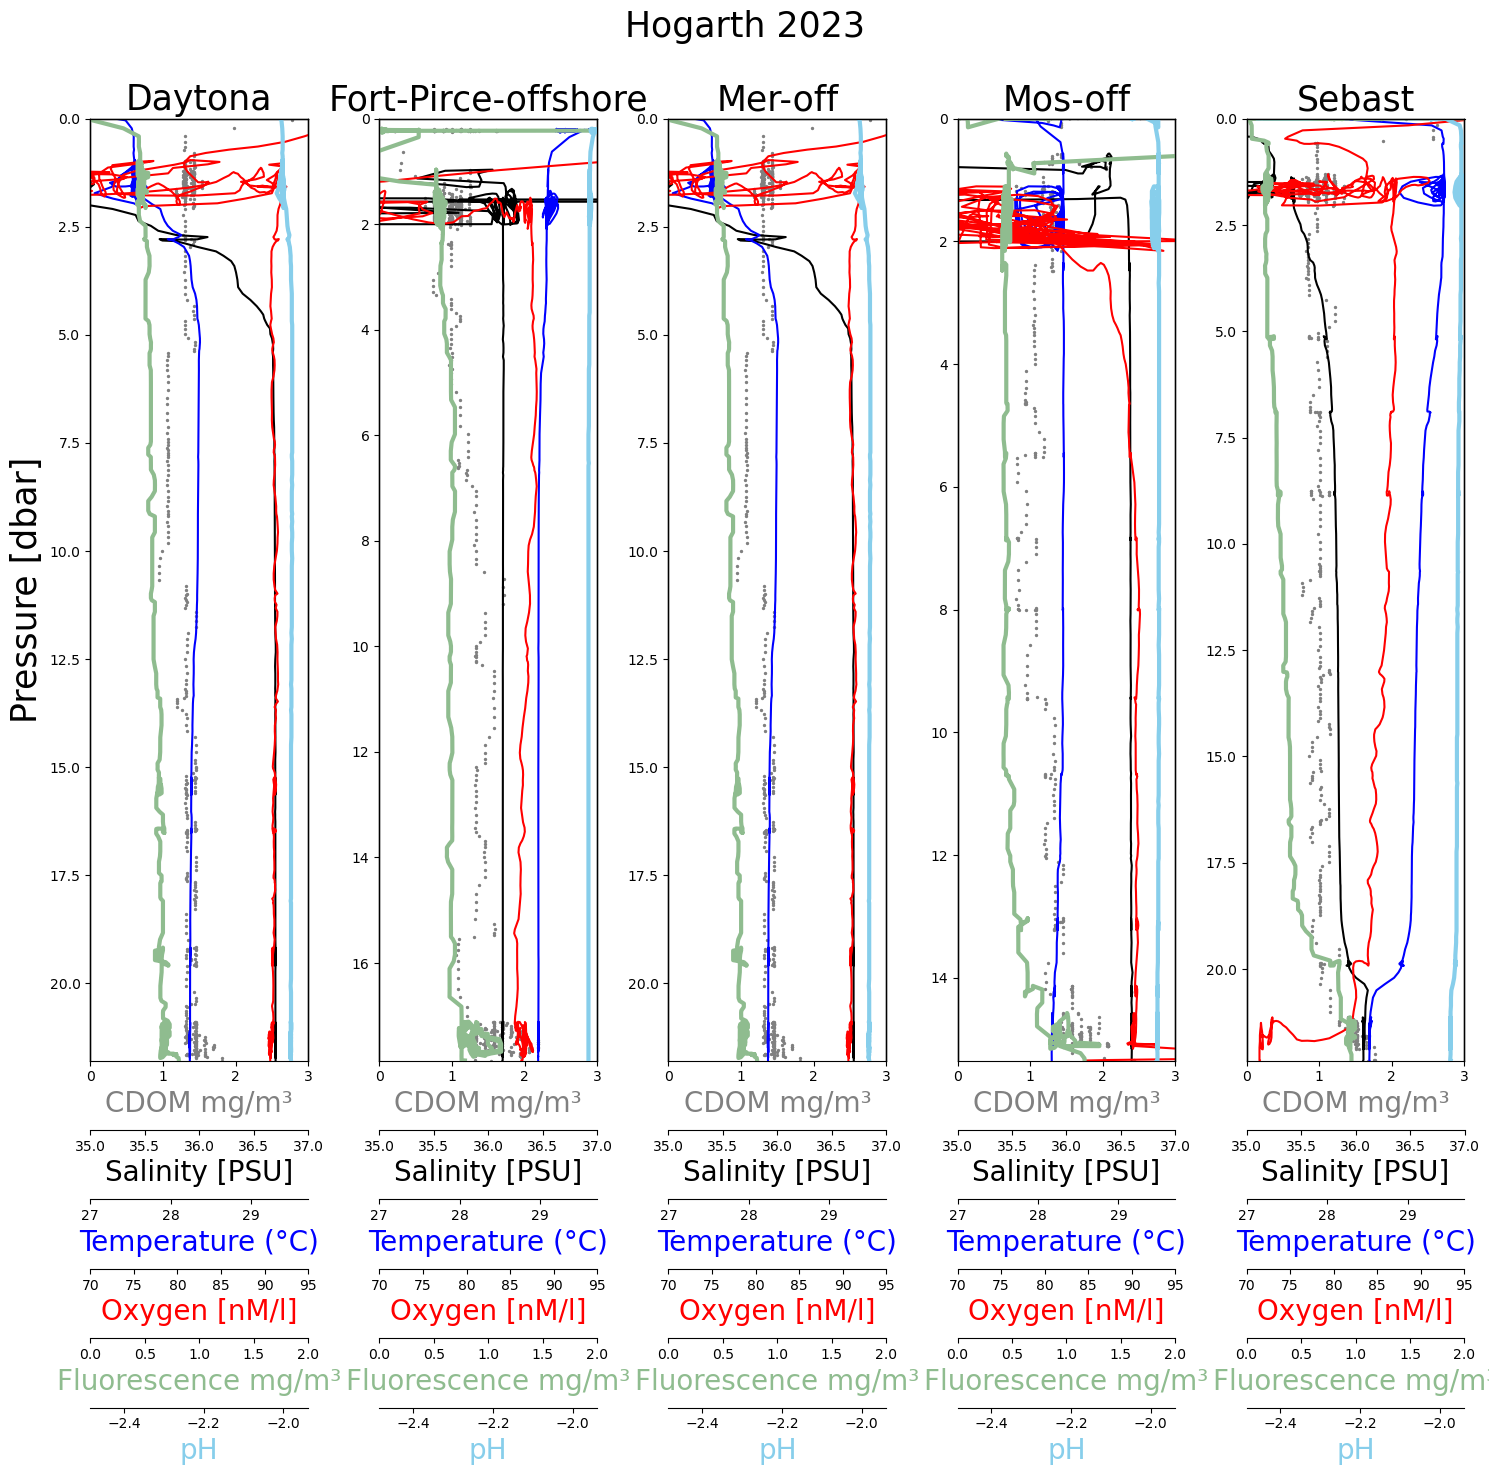

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15, 15))
ds_ctd = ds

for j, station_order in enumerate(station_orders):
    ax = axs[j]
    
    #CTD DATA 
    data = ds_ctd[(ds_ctd['station'] == station_order)]
    
    #CTD pressure DATA 
    pressure = data['Pressure [dbar]'] #X var 
    pressure = np.asarray(pressure, dtype=float).ravel()

    #CTD CDOM DATA 
    wetCDOM = data['wetCDOM']
    wetCDOM = np.asarray(wetCDOM, dtype=float).ravel()

    #CTD flor DATA 
    flECO = data['flECO-AFL'] #X var 
    flECO = np.asarray(flECO, dtype=float).ravel()
    
    #CTD Salinity DATA 
    sal00 = data['sal00'] #X var 
    sal00 = np.asarray(sal00, dtype=float).ravel()
    
    #CTD oxygen DATA
    sbeox = data['sbeox0Mm/L'] #X sbeox0Mm/L 
    sbeox = np.asarray(sbeox, dtype=float).ravel()
    
    #CTD temp DATA
    t090C = data['potemp090C'] #X var 
    t090C = np.asarray(t090C, dtype=float).ravel()
    
    #CTD pH DATA
    ph = data['ph'] #X var 
    ph = np.asarray(ph, dtype=float).ravel()
    
    size = 120 
    edgecolor = 'black'
    linewidth = 1.25
    txt_size = 20
    
    #CTD CDOM
    ax.scatter(wetCDOM, pressure, c='grey', s = 2)
    ax.set_xlim(0,3)
    ax.invert_yaxis()
    ax.set_ylim(bottom = data['Pressure [dbar]'].max(), top = 0)
    #Set x-axis label on bottom subplots
    ax.set_xlabel('CDOM mg/m\u00B3', size = txt_size, c='grey')
    
    #CTD Sal
    ax2 = ax.twiny()
    ax2.plot(sal00, pressure, c = "black")
    ax2.set_xlim(35, 37)
    #Set x-axis label on bottom subplots
    ax2.set_xlabel('Salinity [PSU]', size = txt_size, c= 'black')
    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 50))
    
    #CTD temp
    ax3 = ax.twiny()
    ax3.plot(t090C, pressure, c = "blue")
    ax3.set_xlim(27, ds_ctd['potemp090C'].max())
    #Set x-axis label on bottom subplots
    ax3.set_xlabel('Temperature (°C)', size = txt_size, c='blue')
    ax3.xaxis.set_ticks_position('bottom')
    ax3.xaxis.set_label_position('bottom')
    ax3.spines['bottom'].set_position(('outward', 100))
    
    #CTD oxogen
    ax9 = ax.twiny()
    ax9.plot(sbeox, pressure, c = "red")
    ax9.set_xlim(70, 95)
    #Set x-axis label on bottom subplots
    ax9.set_xlabel('Oxygen [nM/l]', size = txt_size, c='red')
    ax9.xaxis.set_ticks_position('bottom')
    ax9.xaxis.set_label_position('bottom')
    ax9.spines['bottom'].set_position(('outward', 150))
    
    #CTD FLOR
    ax7 = ax.twiny()
    ax7.plot(flECO, pressure, c = "#8FBC8F", linewidth=3.0)
    ax7.set_xlim(0,2)
    #Set x-axis label on bottom subplots
    ax7.set_xlabel('Fluorescence mg/m\u00B3', size = txt_size, c= '#8FBC8F')
    ax7.xaxis.set_ticks_position('bottom')
    ax7.xaxis.set_label_position('bottom')
    ax7.spines['bottom'].set_position(('outward', 200))
    
    #CTD pH
    ax8 = ax.twiny()
    ax8.plot(ph, pressure, c = "skyblue", linewidth=3.0)
    ax8.set_xlim(ds['ph'].min(),ds['ph'].max())
    #Set x-axis label on bottom subplots
    ax8.set_xlabel(r'pH', size = txt_size, c='skyblue')
    ax8.xaxis.set_ticks_position('bottom')
    ax8.xaxis.set_label_position('bottom')
    ax8.spines['bottom'].set_position(('outward', 250))
    
    #set the titels 
    ax.set_title(f'{station_order}', size = 25)
    
    #Set y-axis label on bottom subplots
    if j == 0:
        ax.set_ylabel('Pressure [dbar]', size= 25)
            
# add a global title to the figure
fig.suptitle(r'Hogarth 2023''\n', size = 25)
fig.set_facecolor('w')
plt.tight_layout()

#save plot 
plt.savefig("./CTD_profiles.png")

# show the plot
plt.show()

In [ ]:
STOP

In [ ]:
for f in files_r: 
    rossum = ctd.rosette_summary(f)
    rossum_sum = rossum.groupby(rossum.index).mean()
    ID = f.split("\\")[1]
    ID = ID[:-4].split("_")
    ID = ID[1]+"_"+ID[2]+"_"+ID[3]+"_"+ID[4]
    rossum_sum.to_csv(f"./CDOM_RECAL/GOM21FA/ros_{ID}.csv")



In [ ]:
x = 10
print(files_r[x])
rossum = ctd.rosette_summary(files_r[x])
rossum_sum = rossum.groupby(rossum.index).mean()

In [ ]:
rossum_sum.to_csv('../CTD/ROS_SUMMS/ROSETTE_GOM21FA_ID2153_St2 11-02-21.csv')
rossum_sum

In [ ]:
x = 10
cast = ctd.from_cnv(files_c[x])
down, up = cast.split()

files_c[x]

In [ ]:
down.to_csv('../CTD/DOWNCAST_PROFILE/FALL_2020_St.MK.csv')

In [ ]:
files_c[31]

In [ ]:
style.use("seaborn-whitegrid")

fig, ax = plt.subplots(figsize=(8, 10))
ax1 = down["wetCDOM"].plot_cast(label="Fluorescence, CDOM (mg/m^3)", color="black")
ax2 = down["c0S/m"].plot_cast(label="Conductivity (S/m)", color="blue")
ax3 = down["flECO-AFL"].plot_cast(label="Fluorescence, Biology (mg/m^3)", color="green")
ax4 = down["turbWETbb0"].plot_cast(label="Turbidity (m^-1/sr)", color="orange")
ax5 = down["t090C"].plot_cast(label="Temperature (°C)", secondary_y=True, color="red")
ax1.legend(bbox_to_anchor=(.55, -.1), loc='upper center', borderaxespad=0)
ax5.legend(bbox_to_anchor=(.55, 1.1), loc='upper center', borderaxespad=0)
ax1.grid(False)
ax4.grid(False)
ax1.set_ylabel("Depth (M)")
ax1.set_xlabel("")

In [ ]:
ax0 = down["t090C"].plot_cast(label="Temperature (°C)")
ax1 = down["c0S/m"].plot_cast(
    ax=ax0,
    label="Conductivity (S/m)",
    color="orange",
    secondary_y=True,
)
ax0.grid(False)
ax1.grid(False)

ax0.legend(loc="lower left")
ax1.legend(loc="lower right")

In [ ]:
metadata = cast._metadata
metadata.keys()
print(metadata["header"])

In [ ]:
fig, ax = plt.subplots()
ax.plot(down.index, label="unfiltered")
ax.plot(down.lp_filter().index, label="filtered")
ax.axis([20870, 20930, 557.5, 559])
fig.legend();

In [ ]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

In [ ]:
downcast, upcast = cast.split()
upcast

In [ ]:
ax = downcast['par'].plot_cast()

In [ ]:
figsize = (4, 6)
kw_t = dict(linestyle='-', color='#6699cc', linewidth=3, label=r"Temperature [$^\circ$C]")
kw_ct = dict(linestyle='-', color='#ffcc33', alpha=0.75, linewidth=3, label=r"Conservative temperature [$^\circ$C]")

fig, ax = downcast['c0S/m'].plot(**kw_t)
ax.plot(downcast['dNMEA'], downcast.index, **kw_ct)
ax.grid(True)
ax.set_xlabel("Temperature")
ax.set_ylabel("Pressure [dbar]")
l = ax.legend(loc="lower right")
fig.set_size_inches(figsize)

In [ ]:
# This returns a list of names (strings) of files that have the .txt extension. 
# You should provide the path
files = glob.glob('./SAV-22-06/*')
files

In [ ]:
df = xr.open('./SAV-22-06\\CTD_GOM22SP_St.2_2220_4.17.cnv')